<a href="https://colab.research.google.com/github/ckbjimmy/2019_tokyo/blob/master/causal_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Causal Inference Workshop

Hands-on Workshops by Satoshi Kimura / Wei-Hung Weng / Ryo Uchimido

March 7, 2019 @ TMDU


---
- [`doWhy` GitHub repo](https://github.com/Microsoft/dowhy)
- [`doWhy` document](https://causalinference.gitlab.io/dowhy/)


## Before running all cells, please go to `FILE > Save a copy in Drive` to save the colab notebook to your own Google Drive.

## Install dependencies


We recommend you to use VM provided by Google colab due to package version compatibility.


In [0]:
%%capture 
!git clone https://github.com/Microsoft/dowhy.git
!sudo apt install graphviz libgraphviz-dev graphviz-dev pkg-config
!pip install pygraphviz \
 --install-option="--include-path=/usr/include/graphviz" \
 --install-option="--library-path=/usr/lib/graphviz/"
!pip install -r ./dowhy/requirements.txt
!pip install --upgrade pandas
!pip install --upgrade statsmodels
!python ./dowhy/setup.py install
!wget -P ./dowhy/dowhy/causal_estimators/ \
https://raw.githubusercontent.com/ckbjimmy/2019_tokyo/master/logistic_regression_estimator.py

## Reload the updated packages by manually running `Runtime > Restart runtime` or `Ctrl + M .`

## Load packages

In [0]:
import sys
sys.path.append('dowhy')
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from scipy import stats
from IPython.display import Image, display

from dowhy.do_why import CausalModel
import dowhy.datasets
from dowhy.do_samplers.kernel_density_sampler import KernelDensitySampler
# from dowhy.api.causal_data_frame import CausalDataFrame
from statsmodels.api import OLS, Logit

## Create a data simulator and define a graph

In [0]:
class DataSimulator(object):
    def __init__(self):
        # Specify the model parameters
        self.sample_size = 5000

        # Specify the prevalence of A (exposure)
        self.p_A = 0.2
        
        self.a_0 = np.log(0.05/(1 - 0.05))
        self.a_LA = np.log(5.0)

        # Parameters for the odds of Y (outcome)
        self.y_0 = np.log(0.05/(1 - 0.05)) # log odds of Y for ref group (A = 0, L = 0, and S = 0)
        self.y_AY = np.log(1.0) # log OR for effect of A on log odds of Y (OR = 1.0) no effect
        self.y_LY = np.log(5.0) # log OR for effect of L on log odds of Y (OR = 5.0)
        
        # Parameters for the odds of S (selection)
        self.s_0 = np.log(0.10/(1 - 0.10)) # log odds of S for ref group (A = 0 and L = 0)
        self.s_AS = np.log(5.0) # log OR for effect of A on log odds of selection (OR = 5.0)
        self.s_LS = np.log(5.0) # log OR for effect of L on log odds of selection (OR = 5.0)
        self.s_LA = np.log(1.0)  # log OR for interaction between A and L (OR = 1.0)
    
    def prob_A(self, L):
        return np.exp(self.a_0 + self.a_LA*L)/(1 + np.exp(self.a_0 + self.a_LA*L))
  
    def prob_S(self, A, L):
        return np.exp(self.s_0 + self.s_AS*A + self.s_LS*L + self.s_LA*L*A) / (1 + np.exp(self.s_0 + self.s_AS*A + self.s_LS*L + self.s_LA*L*A))

    def prob_Y(self, A, L):
        return np.exp(self.y_0 + self.y_AY*A +  self.y_LY*L) / (1 + np.exp(self.y_0 + self.y_AY*A +  self.y_LY*L))
      
    def get_graph(self, task):
        if task == 'confounder':
            g = '''
            graph [
            directed 1
            node[id "A" label "A"]
            node[id "Y" label "Y"]
            node[id "L" label "L"]
            edge[source "L" target "A" weight 1]
            edge[source "L" target "Y" weight 1]
            ]
            '''

            d = '''
            digraph {
            L -> A;
            L -> Y;
            }
            '''

            
        elif task == 'collider':
            g = '''
            graph [
            directed 1
            node[id "A" label "A"]
            node[id "Y" label "Y"]
            node[id "S" label "S"]
            node[id "L" label "L"]
            edge[source "A" target "S" weight 1]
            edge[source "L" target "A" weight 1]
            edge[source "L" target "Y" weight 1]
            edge[source "L" target "S" weight 1]
            ]
            '''

            d = '''
            digraph {
            A -> S;
            L -> A;
            L -> Y;
            L -> S;
            }
            '''
            
        return g, d

    def get_data(self, task):
        g, d = self.get_graph(task)
        
        if task == 'confounder':
            ls_L = stats.norm.rvs(size=self.sample_size, loc=0, scale=1)
            p_A = [self.prob_A(ls_L[i]) for i in range(self.sample_size)]
            r = stats.uniform.rvs(size=self.sample_size, loc=0, scale=1)
            ls_A = [1 if p_A[i] > r[i] else 0 for i in range(len(p_A))]
            p_Y = [self.prob_Y(ls_A[i], ls_L[i]) for i in range(self.sample_size)]
            r = stats.uniform.rvs(size=self.sample_size, loc=0, scale=1)
            ls_Y = [1 if p_Y[i] > r[i] else 0 for i in range(len(p_Y))]      
            return pd.DataFrame({
                'A': ls_A, 
                'L': ls_L, 
                'prob_Y': p_Y, 
                'Y': ls_Y
            }, columns=['A', 'L', 'prob_Y', 'Y']), g, d
        
        if task == 'collider':
            ls_A = stats.binom.rvs(size=self.sample_size, n=1, p=self.p_A)
            ls_L = stats.norm.rvs(size=self.sample_size, loc=0, scale=1)
            p_S = [self.prob_S(ls_A[i], ls_L[i]) for i in range(self.sample_size)]
            p_Y = [self.prob_Y(ls_A[i], ls_L[i]) for i in range(self.sample_size)]
            return pd.DataFrame({
                'A': ls_A, 
                'L': ls_L, 
                'prob_S': p_S,
                'prob_Y': p_Y, 
                'S': stats.binom.rvs(size=self.sample_size, n=1, p=p_S),
                'Y': stats.binom.rvs(size=self.sample_size, n=1, p=p_Y)
            }, columns=['A', 'L', 'prob_S', 'prob_Y', 'S', 'Y']), g, d
        

## Confounder bias

First, we simulate some data that the exposure (A) has no effect on outcome (Y).

In [0]:
task = 'confounder'

sim = DataSimulator()
data = {}
data['df'], g, d = sim.get_data(task)
data['treatment_name'] = 'A'
data['outcome_name'] = 'Y'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

In [86]:
data

{'df':       A         L    prob_Y  Y
 0     0  0.043642  0.053444  0
 1     0  0.072292  0.055825  0
 2     0 -0.374992  0.027978  0
 3     0 -1.127004  0.008507  0
 4     0  0.280287  0.076327  0
 5     0 -0.408870  0.026533  0
 6     0  0.821002  0.164779  0
 7     0 -0.564467  0.020777  0
 8     0 -1.028473  0.009955  0
 9     0  0.160343  0.063782  0
 10    0 -0.568329  0.020651  0
 11    0  0.302651  0.078903  0
 12    1  1.230255  0.275994  1
 13    0 -0.070572  0.044872  0
 14    0  0.362986  0.086256  0
 15    1  1.098610  0.235719  0
 16    0 -0.173029  0.038312  0
 17    0 -0.367639  0.028302  0
 18    0 -2.651063  0.000738  0
 19    0  0.691589  0.138075  0
 20    0  0.072016  0.055802  0
 21    0 -0.980636  0.010743  0
 22    0  1.468975  0.358883  1
 23    0 -0.681180  0.017280  0
 24    0 -0.129007  0.041010  0
 25    0  0.283214  0.076660  0
 26    0  0.680934  0.136047  0
 27    0 -0.037779  0.047190  0
 28    0  0.699101  0.139520  0
 29    0 -0.343401  0.029394  0
 .

If we don't consider confounder, where we just consider exposure in our model, we will get the confounder bias.

In [87]:
df = data['df']
model = Logit(df['Y'], df[['A']]) # no confounder L
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.681391
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4999
Method:                           MLE   Df Model:                            0
Date:                Sat, 23 Feb 2019   Pseudo R-squ.:                  -1.110
Time:                        13:54:42   Log-Likelihood:                -3407.0
converged:                       True   LL-Null:                       -1614.4
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.9570      0.093    -10.257      0.000      -1.140      -0.774
==============================================================================
"""

We got exposure coefficient of -0.957 if confounder is not considered, which means the odds ratio is $\exp(-0.957) = 0.384$. This doesn't match what we are expected that odds ratio should close to 1.

### Considering the confounder (L) using causal graph

Step 1 - create a causal model from the data and the graph designed by domain experts. The confounder (L) is included in the graph.

['L']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y


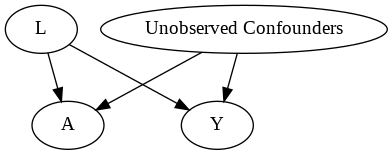

In [88]:
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

Step 2 - Identify causal effect based on the graph, and return target estimands.

In [89]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'L', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!



Step 3 - Estimate the target estimand with different statistical models. In this case, logistic regression. You may change the method to `backdoor.linear_regression` if your outcome variable is continuous.

In [90]:
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.logistic_regression")
print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+L


LogisticRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~A+L
## Estimate
Value: -0.04323355085367407

Causal Estimate is -0.04323355085367407


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Here we find that the exact estimate is -0.043 after considering the confounder, which means the odds ratio is very close to 1 (no effect).

Step 4 - We can use different robustness check methods to reture the obtained estimate. For example, using random common cause. The estimate is still around -0.042.

In [93]:
refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")
print(refute_results)

INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+L+w_random


Refute: Add a Random Common Cause
Estimated effect:(-0.04323355085367407,)
New effect:(-0.043064811657984786,)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Collider bias

Next, we consider collider bias. Again, we start from data simulation. The simulation generates data that again exposure (A) has no effect on outcome (Y) but has effect on collider (S). The confounder (L) instead has both effects on outcome and collider. We want to build a model that should represent this behavior.

In [0]:
task = 'collider'

sim = DataSimulator()
data = {}
data['df'], g, d = sim.get_data(task)
data['treatment_name'] = 'A'
data['outcome_name'] = 'Y'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

This time, if we erroneously consider the collider and include it into our model.

In [98]:
df = data['df']
model = Logit(df['Y'], df[['A', 'S']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.615741
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4998
Method:                           MLE   Df Model:                            1
Date:                Sat, 23 Feb 2019   Pseudo R-squ.:                 -0.8329
Time:                        14:02:05   Log-Likelihood:                -3078.7
converged:                       True   LL-Null:                       -1679.7
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
A             -1.8258      0.105    -17.390      0.000      -2.032      -1.620
S             -0.7280      0.076     -9.568      0.000      -0.877      -0.579
==============================================================================
"""

We get the exposure coefficient of -1.826, i.e. odds ratio is $\exp(-1.826) = 0.162. This is not what we expected that no causal effect from exposure to outcome.

### Considering causal graph

- Step 1 - Create model based on causal graph
- Step 2 - Identify variables
- Step 3 - Estimate by statistical models
- Step 4 - Robustness check

Here we find that the exact estimate is 0.02 (odds ratio near 1) after removing the collider. We want to mention that even though there is an arrow between confounder and treatment, there is no causal effect between them since the coefficient in the simulator is set to be $\log(1.0) = 0$.

['L']
yes
{'observed': 'yes'}
Model to find the causal effect of treatment A on outcome Y


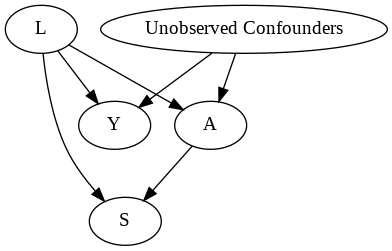

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'L', 'U'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+L
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
INFO:dowhy.causal_estimator:INFO: Using Logistic Regression Estimator
INFO:dowhy.causal_estimator:b: Y~A+L+w_random


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!

LogisticRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
d                   
──(Expectation(Y|L))
dA                  
Estimand assumption 1, Unconfoundedness: If U→A and U→Y then P(Y|A,L,U) = P(Y|A,L)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~A+L
## Estimate
Value: 0.024838118696837372

Causal Estimate is 0.024838118696837372
Refute: Add a Random Common Cause
Estimated effect:(0.024838118696837372,)
New effect:(0.027844238293815892,)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [99]:
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.logistic_regression")

print(estimate)
print("Causal Estimate is " + str(estimate.value))

refute_results = model.refute_estimate(identified_estimand, estimate,
                                       method_name="random_common_cause")

print(refute_results)

## Hands-on exercise: NHEFS data

In [59]:
nhefs = pd.ExcelFile('https://www.dropbox.com/s/nchp1pezska7bim/nhefs.xlsx?dl=1').parse('2017')
nhefs.columns

Index(['seqn', 'qsmk', 'death', 'yrdth', 'modth', 'dadth', 'sbp', 'dbp', 'sex',
       'age', 'race', 'income', 'marital', 'school', 'education', 'ht', 'wt71',
       'wt82', 'wt82_71', 'birthplace', 'smokeintensity', 'smkintensity82_71',
       'smokeyrs', 'asthma', 'bronch', 'tb', 'hf', 'hbp', 'pepticulcer',
       'colitis', 'hepatitis', 'chroniccough', 'hayfever', 'diabetes', 'polio',
       'tumor', 'nervousbreak', 'alcoholpy', 'alcoholfreq', 'alcoholtype',
       'alcoholhowmuch', 'pica', 'headache', 'otherpain', 'weakheart',
       'allergies', 'nerves', 'lackpep', 'hbpmed', 'boweltrouble', 'wtloss',
       'infection', 'active', 'exercise', 'birthcontrol', 'pregnancies',
       'cholesterol', 'hightax82', 'price71', 'price82', 'tax71', 'tax82',
       'price71_82', 'tax71_82'],
      dtype='object')

In [67]:
nhefs.head(5)

,seqn,qsmk,death,yrdth,modth,dadth,sbp,dbp,sex,age,race,income,marital,school,education,ht,wt71,wt82,wt82_71,birthplace,smokeintensity,smkintensity82_71,smokeyrs,asthma,bronch,tb,hf,hbp,pepticulcer,colitis,hepatitis,chroniccough,hayfever,diabetes,polio,tumor,nervousbreak,alcoholpy,alcoholfreq,alcoholtype,alcoholhowmuch,pica,headache,otherpain,weakheart,allergies,nerves,lackpep,hbpmed,boweltrouble,wtloss,infection,active,exercise,birthcontrol,pregnancies,cholesterol,hightax82,price71,price82,tax71,tax82,price71_82,tax71_82
0,233,0.0,0,NaN,NaN,NaN,175.0,96.0,0,42.0,1,19.0,2,7,1,174.1875,79.04,68.946040,-10.093960,47.0,30,-10,29,0,0,0,0,1,1,0,0,0,0,1.0,0,0,0,1,1,3,7.0,0,1,0,0,0,0,0,1,0,0,0,0,2.0,2,NaN,197.0,0.0,2.183594,1.739990,1.102295,0.461975,0.443787,0.640381
1,235,0.0,0,NaN,NaN,NaN,123.0,80.0,0,36.0,0,18.0,2,9,2,159.3750,58.63,61.234970,2.604970,42.0,20,-10,24,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,1,4.0,0,1,0,0,0,0,0,0,0,0,1,0,0.0,2,NaN,301.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969
2,244,0.0,0,NaN,NaN,NaN,115.0,75.0,1,56.0,1,15.0,3,11,2,168.5000,56.81,66.224486,9.414486,51.0,20,-14,26,0,0,0,0,0,0,0,0,0,1,0.0,0,1,0,1,3,4,NaN,0,1,1,0,0,1,0,0,0,0,0,0,2.0,0,2.0,157.0,0.0,1.569580,1.513428,0.551270,0.230988,0.056198,0.320251
3,245,0.0,1,85.0,2.0,14.0,148.0,78.0,0,68.0,1,15.0,3,5,1,170.1875,59.42,64.410117,4.990117,37.0,3,4,53,0,0,0,0,1,0,0,0,0,0,0.0,0,0,0,1,2,3,4.0,0,0,1,1,0,0,0,0,0,0,0,1,2.0,2,NaN,174.0,0.0,1.506592,1.451904,0.524902,0.219971,0.054794,0.304993
4,252,0.0,0,NaN,NaN,NaN,118.0,77.0,0,40.0,0,18.0,2,11,2,181.8750,87.09,92.079251,4.989251,42.0,20,0,19,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,2,1,2.0,0,1,0,0,0,0,0,0,1,0,0,1,1.0,2,NaN,216.0,0.0,2.346680,1.797363,1.364990,0.571899,0.549316,0.792969


['diabetes', 'age']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment qsmk on outcome wt82_71


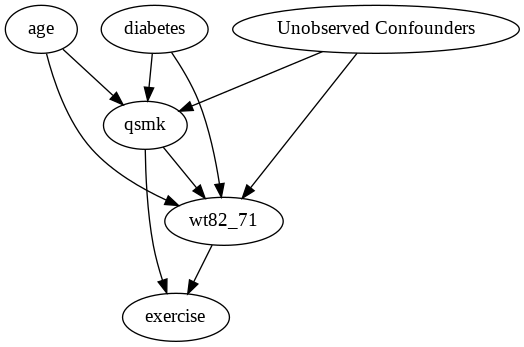

In [60]:
g = '''
graph [
directed 1
node[id "qsmk" label "qsmk"]
node[id "wt82_71" label "wt82_71"]
node[id "age" label "age"]
node[id "diabetes" label "diabetes"]
node[id "exercise" label "exercise"]
edge[source "qsmk" target "wt82_71" weight 1]
edge[source "qsmk" target "exercise" weight 1]
edge[source "wt82_71" target "exercise" weight 1]
edge[source "age" target "qsmk" weight 1]
edge[source "age" target "wt82_71" weight 1]
edge[source "diabetes" target "qsmk" weight 1]
edge[source "diabetes" target "wt82_71" weight 1]
]
'''

d = '''
digraph {
qsmk -> wt82_71;
qsmk -> exercise;
age -> qsmk;
age -> wt82_71;
diabetes -> qsmk;
diabetes -> wt82_71;
wt82_71 -> exercise;
U[label="Unobserved Confounders"];
U -> qsmk;
U -> wt82_71;
}
'''

selected = ['age', 'diabetes', 'qsmk', 'wt82_71', 'exercise']

data = {}
data['df'] = nhefs[selected]
data['treatment_name'] = 'qsmk'
data['outcome_name'] = 'wt82_71'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

In [61]:
identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True)

print(estimate)
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'diabetes', 'U', 'age'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: wt82_71~qsmk+diabetes+age


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|diabetes,age))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,diabetes,age,U) = P(wt82_71|qsmk,diabetes,age)
### Estimand : 2
Estimand name: iv
No such variable found!

LinearRegressionEstimator


ValueError: ignored

In [62]:
nhefs[selected].isnull().values.any()

True

['diabetes', 'age']
yes
{'observed': 'yes'}
yes
{'observed': 'yes'}
Model to find the causal effect of treatment qsmk on outcome wt82_71


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was 

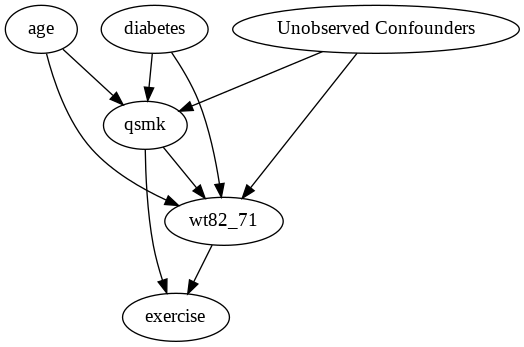

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'diabetes', 'U', 'age'}


{'observed': 'yes'}
{'label': 'Unobserved Confounders', 'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: wt82_71~qsmk+diabetes+age


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|diabetes,age))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,diabetes,age,U) = P(wt82_71|qsmk,diabetes,age)
### Estimand : 2
Estimand name: iv
No such variable found!

LinearRegressionEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                     
─────(Expectation(wt82_71|diabetes,age))
dqsmk                                   
Estimand assumption 1, Unconfoundedness: If U→qsmk and U→wt82_71 then P(wt82_71|qsmk,diabetes,age,U) = P(wt82_71|qsmk,diabetes,age)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: wt82_71~qsmk+diabetes+age
## Estimate
Value: 2.991085165842603

## Statistical Significance
p-value: <0.001

Causa

In [63]:
from sklearn.preprocessing import Imputer

nhefs_imputed = nhefs
for i in selected:
  imputer = Imputer(missing_values="NaN", strategy="mean")
  nhefs_imputed[i] = imputer.fit_transform(nhefs[[i]]) 

data = {}
data['df'] = nhefs_imputed
data['treatment_name'] = 'qsmk'
data['outcome_name'] = 'wt82_71'
data['gml_graph'] = g.replace('\n', '')
data['dot_graph'] = d.replace('\n', '')

model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"])

model.view_model()
display(Image(filename="causal_model.png"))

identified_estimand = model.identify_effect()
print(identified_estimand)

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True)

print(estimate)
print("Causal Estimate is " + str(estimate.value))

In [0]:
# df = data['df']
# df['Y'] = df['Y'] + np.random.normal(size=len(df)) # without noise, the variance in Y|X, Z is zero, and mcmc fails.

# cdf = CausalDataFrame(df)
# cdf.causal.do(x={'A': 1}, 
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'}, 
#               outcome='Y',
#               method='mcmc', 
#               common_causes=['C'],
#               keep_original_treatment=True,
#               proceed_when_unidentifiable=True).groupby('A').mean().plot(y='Y', kind='bar')

# cdf = CausalDataFrame(df)

# cdf_1 = cdf.causal.do(x={'A': 1}, 
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'}, 
#               outcome='Y',
#               method='mcmc', 
#               dot_graph=data['dot_graph'],
#               proceed_when_unidentifiable=True)

# cdf_0 = cdf.causal.do(x={'A': 0}, 
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'b', 'S': 'b'}, 
#               outcome='Y',
#               method='mcmc', 
#               dot_graph=data['dot_graph'],
#               proceed_when_unidentifiable=True,
#               use_previous_sampler=True)

# print((cdf_1['Y'] - cdf_0['Y']).mean())
# print(1.96*(cdf_1['Y'] - cdf_0['Y']).std() / np.sqrt(len(cdf)))

# cdf_do = cdf.causal.do(x={'A': 0}, 
#               variable_types={'A': 'b', 'C': 'c', 'Y': 'c'}, 
#               outcome='Y',
#               method='mcmc', 
#               common_causes=['C'],
#               keep_original_treatment=True,
#               proceed_when_unidentifiable=True).groupby('A').mean().plot(y='Y', kind='bar')